# L41: Lab 1 - Getting started with kernel tracing - I/O

This Jypterlab Notebook is intended to get you started with:

1. Building and running the benchmark
2. Extracting and plotting data collected by the benchmark itself (e.g., execution time)
3. Extracting and plotting data collected externally by DTrace

This file is not intended to be a template for your solutions; we recommend that you create a new Notebook, placing your work there, rather than using this Notebook as your starting point.

Make sure to run cells in the right order (pressing Ctrl-Enter when in the cell) so that dependencies are executed in the right order. For example, Python imports must occur before running the remainder of the code, and data must be collected before it can be plotted.

# 1. Building and running the benchmark

First, we need to build the benchmark using `make` (no text output is expected from a successful build):

In [32]:
!make -C io

Next, we can run the benchmark using Jupyter's `!` syntax, illustrating its command-line arguments:

In [33]:
!io/io-dynamic

usage: io-dynamic -c|-r|-w [-Bdjqsv] [-b buffersize]
    [-n iterations] [-t totalsize] path

Modes (pick one):
    -c              'create mode': create benchmark data file
    -r              'read mode': read() benchmark
    -w              'write mode': write() benchmark

Optional flags:
    -B              Run in bare mode: no preparatory activities
    -d              Set O_DIRECT flag to bypass buffer cache
    -g              Enable getrusage(2) collection
    -j              Output as JSON
    -q              Just run the benchmark, don't print stuff out
    -s              Call fsync() on the file descriptor when complete
    -v              Provide a verbose benchmark description
    -b buffersize   Specify the buffer size (default: 16384)
    -n iterations   Specify the number of times to run (default: 1)
    -t totalsize    Specify the total I/O size (default: 16777216)


Run a quick test of the benchmark using small parameters so that we can see the JSON format of the output, which you will need to know in order to extract various results of interest:

In [59]:
!io/io-dynamic -b 262144 -g -j -v -n 2 -r iofile

{
  "host_configuration": {
    "hw.machine": "arm64",
    "hw.model": "ARM Cortex-A72 r0p3",
    "hw.ncpu": 4,
    "hw.physmem": 8421621760,
    "hw.cpufreq.arm_freq": 600000000
  },
  "benchmark_configuration": {
    "buffersize": 262144,
    "totalsize": 16777216,
    "blockcount": 0,
    "operation": "read",
    "path": "iofile",
    "iterations": 2
  },
  "benchmark_samples": [
    {
      "bandwidth": 1212394.00,
      "time": "0.013513759",
      "utime": "0.000000",
      "stime": "0.013528",
      "inblock": 0,
      "oublock": 0
    },
    {
      "bandwidth": 1203120.04,
      "time": "0.013617926",
      "utime": "0.000000",
      "stime": "0.013630",
      "inblock": 0,
      "oublock": 0
    }
  ]
}


The `"host_configuration"` and `"benchmark_configuration"` blocks provide information about the configuration of the host and the benchmark.

The `"benchmark_samples`" block consists of an array of individual measurements with various results for each measurement. In general, dropping the first sample is a good idea, as it may contain artifacts from "first runs" -- such as the costs of dynamic linking. The captured metrics using this benchmark command line are:

- `bandwidth`: The average bandwidth over the run of the benchmark's work loop.
- `time`: Wall-clock time running the work loop.
- `utime` and `stime`: Sampled user and system (kernel) time. This may not add up to wall-clock time if software has to sleep awaiting I/O. Further, while `time` is measured using precise clock reads, `utime` and `stime` are sampled by the timer interrupt. You therefore cannot expect that (`time` == `utime` + `stime`).
- `inblock` and `outblock`: The number of actual block I/O operations performed by the process measured using `getrusage(2)`.

# 2. Extracting and plotting data generated by the benchmark

Next, we import some Python module dependencies, and set configuration parameters:

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Set low for experimentation; consider using 11 "in production", but this will run for a long time!
iterations=4

Next, run the benchmark and process the results. We run the benchmark binary once for each buffer size, `iterations` times, generating JSON. We import the JSON into Python, and generate some summary statistics (medians and quartiles) for each buffer size. In this example, we consider only bandwidth, but you can also easily plot properties such as 

In [5]:
benchmark_strings = {}
for blocksize in [2**v for v in range(25)]:
    output = !io/io-dynamic -b $blocksize -j -n $iterations -r -v iofile
    benchmark_strings[blocksize] = ' '.join(output)
    
bw_samples = {}       # Arrays of bandwidth samples indexed by block size
medians = {}          # Arrays of medians indexed by block size
stds = {}             # Arrays of standard deviations indexed by block size
q3s = {}              # Arrays of third quartiles
q1s = {}              # Arrays of first quartiles

for blocksize in [2**v for v in range(25)]:
    j = json.loads(benchmark_strings[blocksize])
    samples = list(j["benchmark_samples"])
    bw_samples[blocksize] = list([x["bandwidth"] for x in samples])
    medians[blocksize] = np.median(bw_samples[blocksize])
    q1s[blocksize] = medians[blocksize] - np.quantile(bw_samples[blocksize], 0.25)
    q3s[blocksize] = np.quantile(bw_samples[blocksize], 0.75) - medians[blocksize] 

Finally, we generate a plot using `matplotlib`, consisting of medians and error bars based on IQR:

<ErrorbarContainer object of 3 artists>

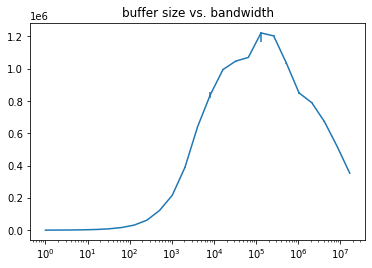

In [45]:
fig1, ax = plt.subplots()
ax.set_title("buffer size vs. bandwidth")

x_coords = []
y_coords = []
low_errs = []
high_errs = []

for x in [2**v for v in range(25)]:
    x_coords.append(x)
    y_coords.append(medians[x])
    low_errs.append(q1s[x])
    high_errs.append(q3s[x])

ax.set_xscale("log")
ax.errorbar(x_coords, y_coords, [low_errs, high_errs])

In analysing this plot, it is worth considering key inflection points: Points on the plot where there are behavioural changes, and what they reflect. We can directly annotate those points on the plot using `avxline`.

In the next plot, we've manually placed several vertical lines at points where the data you collect is likely to experience inflection points. If they don't line up, check that you are collecting data as expected.

Be sure to take note of the linear Y axis and exponential X axis, and consider its implications for data analysis.

<ErrorbarContainer object of 3 artists>

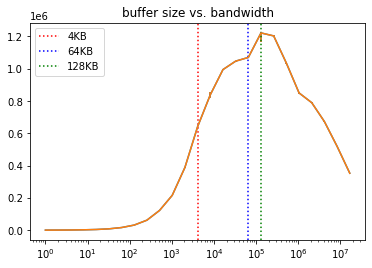

In [55]:
### This content the same as the above cell
fig1, ax = plt.subplots()
ax.set_title("buffer size vs. bandwidth")

x_coords = []
y_coords = []
low_errs = []
high_errs = []

for x in [2**v for v in range(25)]:
    x_coords.append(x)
    y_coords.append(medians[x])
    low_errs.append(q1s[x])
    high_errs.append(q3s[x])

ax.set_xscale("log")
ax.errorbar(x_coords, y_coords, [low_errs, high_errs])

### This is new content relative to the prior cell
ax.axvline(x=4*1024, color="red", label="4KB", linestyle=":")
ax.axvline(x=64*1024, color="blue", label="64KB", linestyle=":")
ax.axvline(x=128*1024, color="green", label="128KB", linestyle=":")
ax.legend()
ax.errorbar(x_coords, y_coords, [low_errs, high_errs])

# 3. Extracting and plotting data generated using DTrace